# Домашнее задание №2 - Линейные модели. Градиентный спуск

В этом домашнем задании мы с вами научимся обучать линейные модели регрессии и классификации при помощи очень мощного, но в то же время довольно понятного алгоритма, который называется **градиетный спуск**. Помимо линейных моделей он используется и для обучения самых сложных нейронных сетей! Также мы потренируемся применять готовые реализации линейных моделей для задач регрессии и бинарной классификации.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score,
                             mean_squared_error)
from sklearn.model_selection import train_test_split

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

#### Маленькое теоретическое отступление

Основное свойство антиградиента (-1 * градиент) &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента, пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (коэффициентов линейной модели) ((например, нулевой или сгенерированный из некоторого, случайного распределения)). Тогда обычный градиентный спуск состоит в повторении следующих шагов до сходимости:


$$
    w_{k + 1} = w_{k} - \eta \nabla_{w} Q(w_{k}),
$$

где $\nabla_{w} Q(w_{k})$ &ndash; градиент функции потерь в точке $w_k$, а $\eta$ &ndash; скорость обучения (learning rate).

Градиентный спуск обычно останавливают, когда прошло заданное максимальное количество итераций или когда графиент близок к нулю (т.е. наши параметры практически не меняются). Для реализации второго варианта считают норму градиента (по сути длину вектора). Это можно сделать несколькими способами:

$$
l1_{norm} = \sum{|w_i|}
$$

$$
l2_{norm} = \sum{(w_i)^{2}}
$$

Попробуем разобраться на простом примере. Рассмотрим функцию от двух переменных:
$f(x, y) = \sin^2 x + \sin^2 y$

In [3]:
def f(w):
    """
    :param w: np.array(np.float) вектор из 2-х элементов
    :return: np.float
    """
    
    return np.sum(np.sin(w)**2)

Обратите внимание, что $x$ - numpy-array вектор длины 2.

***Reminder:***  
Что мы хотим? Мы хотим найти минимум этой функции (в машинном обучении мы обычно хотим найти минимум **функции потерь**, например, MSE), а точнее найти $w_1$ и $w_2$ такие, что при них значение $f(w_1, w_2)$ минимально, то есть *точку экстремума*.  
  
Как мы будем искать эту точку? Используем методы оптимизации (в нашем случае - *минимизации*). Одним из таких методов и является **градиентный спуск**.

### Задание 1. Градиентный спуск для функции $f$ (1 балл)

Реализуйте функцию, которая будет осуществлять градиентный спуск для функции $f$:

*Примечание:* Вам нужно посчитать частные производные именно **аналитически** и **переписать их в код**, а не считать производные численно (через отношение приращения функции к приращению аргумента) -- в этих двух случаях могут различаться ответы, поэтому будьте внимательны.

In [4]:
def grad_f(w): 
    """
    Градиент функциии f, определенной выше.
        :param w: np.array[2]: float вектор из 2-х элементов
        :return: np.array[2]: float вектор из 2-х элементов
    """
    x, y = w
    return np.array([2*np.sin(x)*np.cos(x), 2*np.sin(y)*np.cos(y)])

Проверим, что градиент принимает вектор из двух чисел и выдает на этой точке верное значение

In [5]:
assert np.allclose(grad_f(np.array([1, 2])), 
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"

In [6]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    Функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array[num_iter, 2] пар вида (x, f(x))
    """
    
    w0 = np.random.random(2)

    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла == шаг градиентнго спуска
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)
    
        curr_w -= lr * grad_f(curr_w)

    return np.vstack(history)

Визуализируем точки градиентного спуска на 3D-графике нашей функции. Звездочками будут обозначены точки (тройки $w_1, w_2, f(w_1, w_2)$), по которым Ваш алгоритм градиентного спуска двигался к минимуму (Для того, чтобы написовать этот график, мы и сохраняли значения $cur\_w_1, cur\_w_2, f(cur\_w_1, cur\_w_2)$ в `steps` в процессе спуска).

Если у Вас правильно написана функция `grad_descent_2d`, то звездочки на картинке должны сходиться к одной из точек минимума функции. Вы можете менять начальные приближения алгоритма, значения `lr` и `num_iter` и получать разные результаты.

In [7]:
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=20):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    ax = fig.gca(projection="3d")

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker=".", markersize=10, zorder=3, 
            markerfacecolor="y", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=60)
    plt.show()
    
    return steps

/var/folders/95/_sf15gzd0tn54994y567_dk40000gn/T/ipykernel_26467/194902086.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


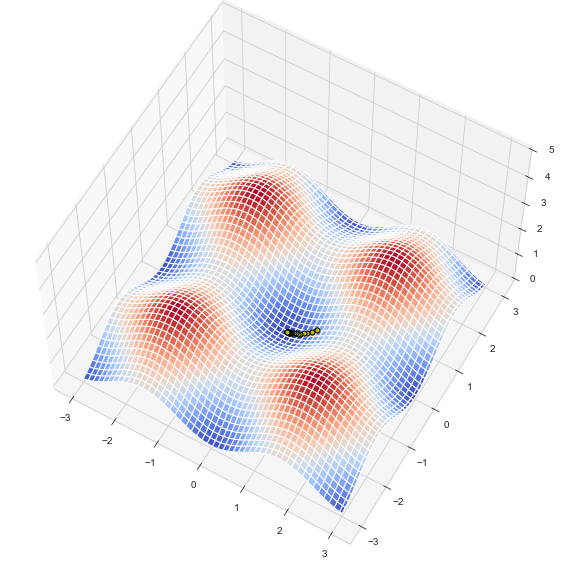

In [8]:
steps = gradient_desc_vis(f, grad_f)

Посмотрим на зависимость значения функции от шага градиентного спуска.

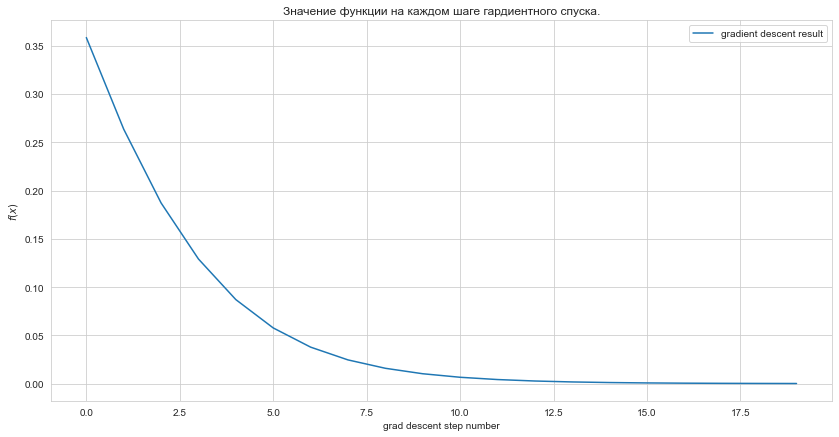

In [9]:
plt.figure(figsize=(14,7))
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.title("Значение функции на каждом шаге гардиентного спуска.")

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result")
plt.legend();

### Задание 2. Реализация линейной регресии (суммарно 9 баллов)

Так как мы будем использовать градиентный спуск для обучения модели, важной часть является реализация функции потерь и функции для расчета ее градиента. Перем началом стоит напомнить, как считать градиент MSE. Вывод этой формулы можно найти  [здесь](https://medium.com/analytics-vidhya/linear-regression-gradient-descent-intuition-and-math-c9a8f5aeeb22)

$$
    MSE = \frac{1}{N}\sum(y_{true} - y_{pred}) ^ 2
$$

$$
    \nabla{MSE} = \frac{2}{N} X^T (y_{pred} - y_{true})
$$

Здесь имеется в виду именно матричное умножение.

#### Задание 2.1. MSE и ее градиент (2 балла)

In [10]:
def mse(y_true, y_pred):
    """
    Функция потерь MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    return np.sum((y_true - y_pred)**2) / len(y_true)
    


def mse_grad(y_true, y_pred, X):
    """
    Функция для расчета градиента MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь MSE
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    return (2 / len(y_true)) * (X.transpose() @ (y_pred - y_true))


class MSELoss:
    """
    Класс, реализующий функцию потерь MSE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)

Мы будем использовать следующий класс для расчета градиента наших функций потерь:

In [11]:
class BasicGradientDescent:
    """
    Класс, позволяющий делать шаги градиентного спуска,
    а также рассчитывающих норму градиента.
    """
    
    def __init__(self, loss_function, grad_norm):
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):
        grad_i = self.loss.calculate_gradient(y, y_pred, X)
        grad_i_norm = self._calculate_grad_norm(grad_i)
        
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):
        if self.grad_norm == "l1":
            return np.abs(grad_i).sum()
        elif self.grad_norm == "l2":
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

В данном задании нужно будет реализовать линейную регрессию и обучить ее при помощи градиентного спуска. Для этого нужно будет заполнять пропуски кода в соответствующих классах. Для начала мы реализуем базовый класс для всех линейных моделей, от которого потом будем наследоваться при реализации линейной и логистической регресий. Не переживайте, этот класс уже реализован, вам достостаточно просто разобраться с кодом.

In [12]:
class BaseLinearModel:
    """
    Класс, который представляет из себя базовую линейную модель, наследуюясь от которого, мы будем
    реализовывать линейную и логистическую регрессии.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
        Конструктор нашего класса. 
            :param learning_rate: скорость обучения
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param fit_intercept: нужно ли нам включать свободных член в модель
            :param n_iter: количество итераций градиентного спуска
            :param tol: параметр для остановки градиентного спуска,
                        если норма градиента (l1 или l2) меньше tol, то останавливаемся
            :param optimizer: класс, который будет рассчитывать градиент и его норму
            :param grad_norm: тип нормы градиента l1 или l2
        """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # В начале параметры модели не заданы
        self.W = None
        
        
    def fit(self, X, y):
        """
        Метод для обучения нашей модели 
            :param X: матрица объекты x признаки
            :param y: вектор значений целевой переменной
            :return: обученная модель
        """
        
        # Сделаем из y вектор-столбец (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Добавим колонку из 1 в матрицу X
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        
        n_features = X_new.shape[1]
        
        # Инициализируем веса модели
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
        
        # Обучаем модель градиентным спуском
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)
            
            # Если градиент близок к 0, останавливаемся
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
    
    
    def __repr__(self):
        return "Base linear model without prediction skill :("

#### Задание 2.2. Предсказания линейной регрессии (3 балла)

Реализуйте метод `predict` у класса `CustomLinearRegression`, не забудьте про свободный член!

In [13]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        # Если вы не проходили наследование и в частности `super`, то не страшно
        # коротко, с помощью этого мы можем вызывать методы родительского класса
        # в частности здесь мы используем метод `init`
        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
        
    
    def predict(self, X_test):
        """
        Метод для вычисления предсказаний 
            :param X_test: np.array[n_test_samples, n_features]: 
                           матрица объекты x признаки (тестовый датасет)
            :return: y_pred: np.array[n_test_samples, 1]: предсказания модели
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        
        return X_test @ self.W
    
    
    def __repr__(self):
        return "My custom linear regression"

##### Проверим нашу реализацию на простом примере

In [14]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

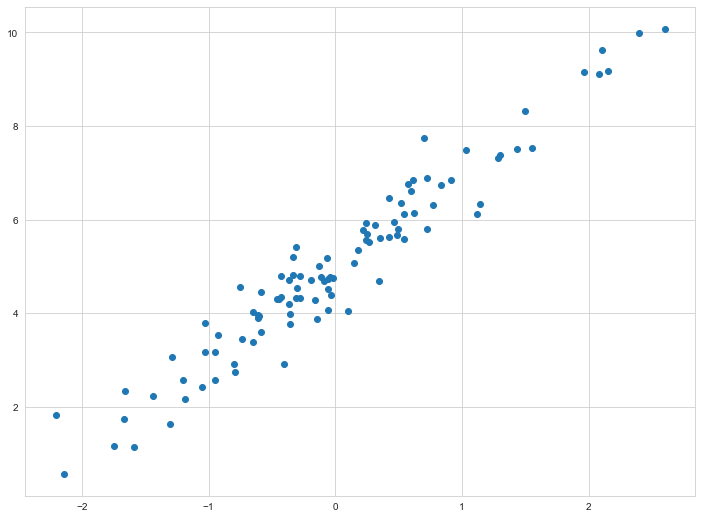

In [15]:
plt.scatter(X, y);

In [17]:
custom_lin_reg = CustomLinearRegression()

In [18]:
custom_lin_reg.fit(X, y)

My custom linear regression

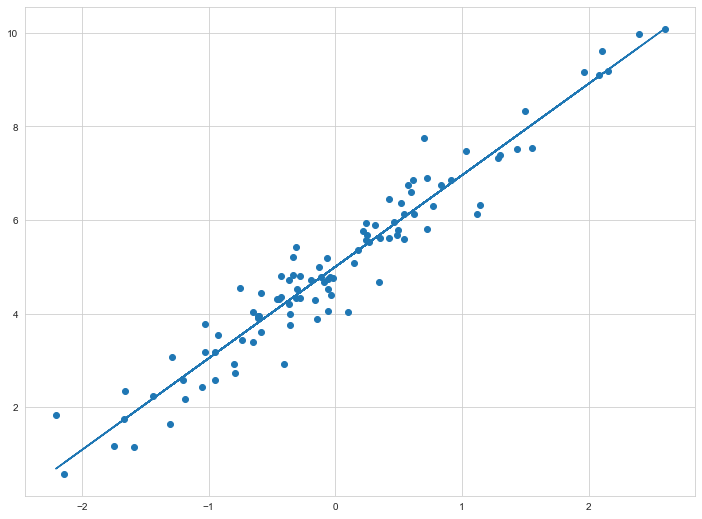

In [19]:
plt.scatter(X, y)
plt.plot(X, custom_lin_reg.predict(X));

#### Задание 2.3. Используем встроенную линейную регрессию (4 балла)

Поработаем с данными о ценах на дома в Бостоне. Постройте модель линейной регресии при помощи `LinearRegression` из `sklearn`. Не забудьте разделить данные на тренировочную и тестовую части, а также правильно предобработать признаки. В конце воспользуйтесь какими-то изученными метриками регресии и сделайте выводы о качестве полученной модели, а также о том, какие признаки наиболее важны с точки зрения полученной модели.

In [20]:
from sklearn.metrics import mean_absolute_percentage_error, explained_variance_score

In [21]:
%%capture
data = load_boston()
X, y = data["data"], data["target"]
feature_names = data["feature_names"]

Ваш ход:

In [22]:
print(f'The shape of input sample is {X.shape}')
print(f'Features: {feature_names}')

The shape of input sample is (506, 13)
Features: ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [23]:
# разбиение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(y_train), len(y_test))

404 102


In [24]:
# создание и обучение модели
reg = LinearRegression().fit(X_train, y_train)
print(f'Intercept: {reg.intercept_}')
for f, c in zip(feature_names, reg.coef_):
    print(f'{f} - {c}')
    
y_pred = reg.predict(X_test)

print()
print(f'R2 score: {r2_score(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'Mean absolute percentage error: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'Explained variance: {explained_variance_score(y_test, y_pred)}')

Intercept: 30.246750993923886
CRIM - -0.11305592398537852
ZN - 0.03011046414564885
INDUS - 0.040380720413338206
CHAS - 2.7844382035079556
NOX - -17.202633391781504
RM - 4.438835199513037
AGE - -0.0062963622109811395
DIS - -1.4478653685307887
RAD - 0.2624297355850854
TAX - -0.010646786275308268
PTRATIO - -0.9154562404680741
B - 0.012351334729969035
LSTAT - -0.5085714244487954

R2 score: 0.6687594935356322
MSE: 24.291119474973502
Mean absolute percentage error: 0.1686639453937866
Explained variance: 0.6695178614705704


Нибольший вес в полученной модели имеют фичи NOX (это прямол основной признак для модели), RM, CHAS, DIS, PTRATIO, LSTAT и тд (в порядке убывания по модулю)
  
В целом R2 показывает, что модель обладает определенной предсказательной силой. Средняя ошибка модели 17%
  
**Посмотрим, как повлияет нормализация данных:**

In [25]:
pipeline = Pipeline([('scaler', StandardScaler()), ('linear_regressor', LinearRegression())])

pipeline.fit(X_train, y_train)

model = pipeline.named_steps['linear_regressor']
print(f'Intercept: {model.intercept_}')
for f, c in zip(feature_names, model.coef_):
    print(f'{f} - {c}')
    
y_pred = pipeline.predict(X_test)

print()
print(f'R2 score: {r2_score(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'Mean absolute percentage error: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'Explained variance: {explained_variance_score(y_test, y_pred)}')

Intercept: 22.796534653465375
CRIM - -1.0021353343041546
ZN - 0.6962686220758474
INDUS - 0.2780648451067007
CHAS - 0.718738404973568
NOX - -2.0223193971459867
RM - 3.1452395637913795
AGE - -0.17604788350520628
DIS - -3.081907599924512
RAD - 2.2514066558289803
TAX - -1.76701377770534
PTRATIO - -2.037751512131359
B - 1.1295683149925626
LSTAT - -3.6116584152726476

R2 score: 0.668759493535632
MSE: 24.29111947497352
Mean absolute percentage error: 0.1686639453937872
Explained variance: 0.6695178614705699


Видим, что стандартизация влияет лишь на коэфициенты модели (так как измениллись абсолютные значения признаков), однако метрики остаются неизменными

### Задание 3. Реализация логистической регресии (суммарно 10 баллов)

Логистическая регрессия не очень сильно отличается от обычной линейной регрессии и используется в задах классификации. Так как здесь мы снова будем пользоваться градиентным спуском, то нужно определить функцию потерь и ее градиент. Одним из самых популярных вариантов в задаче бинарной классификации является бинарная кросс-энтропия (BCE).

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Единственная проблема данной функции это возможность получить 0 под знаком логарифма, что не очень хорошо. Попробуем справить с этим "в лоб". Скажем, что наши предсказания могут принимать значения от 0 + eps до 1 - eps, где eps очень маленькое число.

#### Задание 3.1. Реализация сигмоиды (0.5 баллов)

Реализуйте функцию `sigmoid`, которая переводит действительное число $\mathbb R$ в вероятность $[0,1]$.

In [26]:
def sigmoid(output):
    # output результат X@w (-inf, +inf)
    return 1 / (1 + np.exp(-output))

#### Задание 3.2. BCE Loss и ее градиент (2.5 балла)

Так как мы с вами только начинаем изучать машинное обучение, то было бы слишком жестоко просить вас вычислить градиент BCE Loss (он не так сложен, просто нужно привыкнуть). Поэтому сразу напишем формулу для него:

$$
\nabla{\mathcal L_{BCE}(y, \hat y), X} = X^T (\sigma({\hat{y}}) - y)
$$

In [27]:
def bce(y_true, y_pred, eps=1e-15):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    
    # So I want escape log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    
    return - np.sum(y_ture * np.log(y_pred) - (1 - y_ture) * np.log(1 - y_pred))
    

def bce_grad(y_true, y_pred, X):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
    
    grad = X.transpose() @ (y_pred - y_true)
    return grad.reshape(len(grad), 1)


class BCELoss:
    """
    Класс, реализующий функцию потерь BCE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return bce(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return bce_grad(y_true, y_pred, X)

#### Задание 3.3. Предсказания логистической регрессии (2 балла)

Реализуйте метод `predict` у класса `CustomLogisticRegression`, не забудьте про свободный член!

In [28]:
class CustomLogisticRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-3,
                 loss_function=BCELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate,
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    
    def predict(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        sums = X_test @ self.W
        
        return np.fromiter((sigmoid(s) for s in sums), sums.dtype).reshape(-1, 1)
    
    
    def __repr__(self):
        return "My custom logistic regression"

#### Снова проверим работу алгоритма на простом примере

In [38]:
# Создадим датасет из 1 признака и 2 классов
X, y = make_classification(n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1)

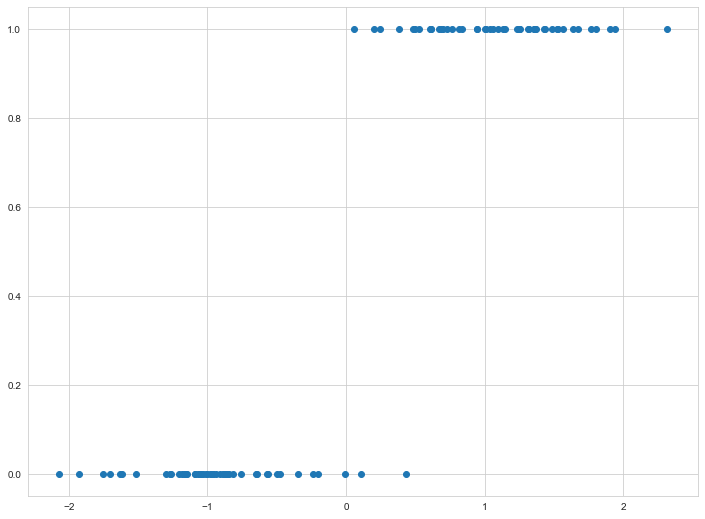

In [39]:
plt.scatter(X, y);

In [40]:
custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X, y)
y_pred = custom_log_reg.predict(X)

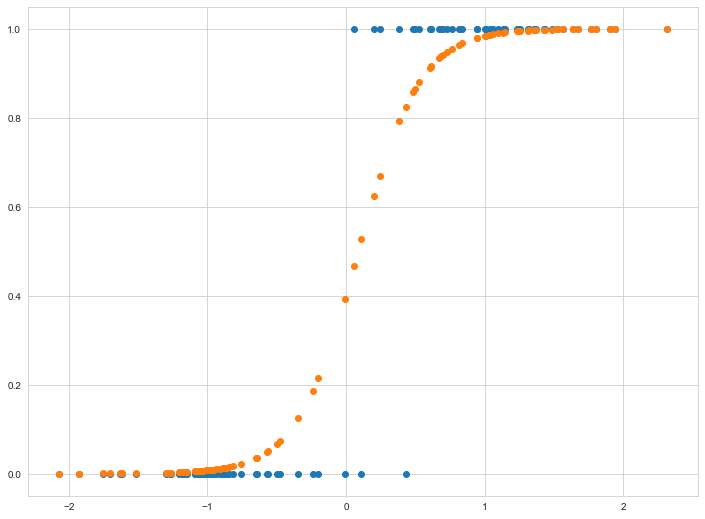

In [41]:
plt.scatter(X, y)
plt.scatter(X, y_pred);

Проверьте качество работы модели при помощи известных вам метрик бинарной классификации. 

Для этого установим разные пороги вероятности для отнесения объекта к классу 1 и посмотрим на изменение характеристик:

In [42]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

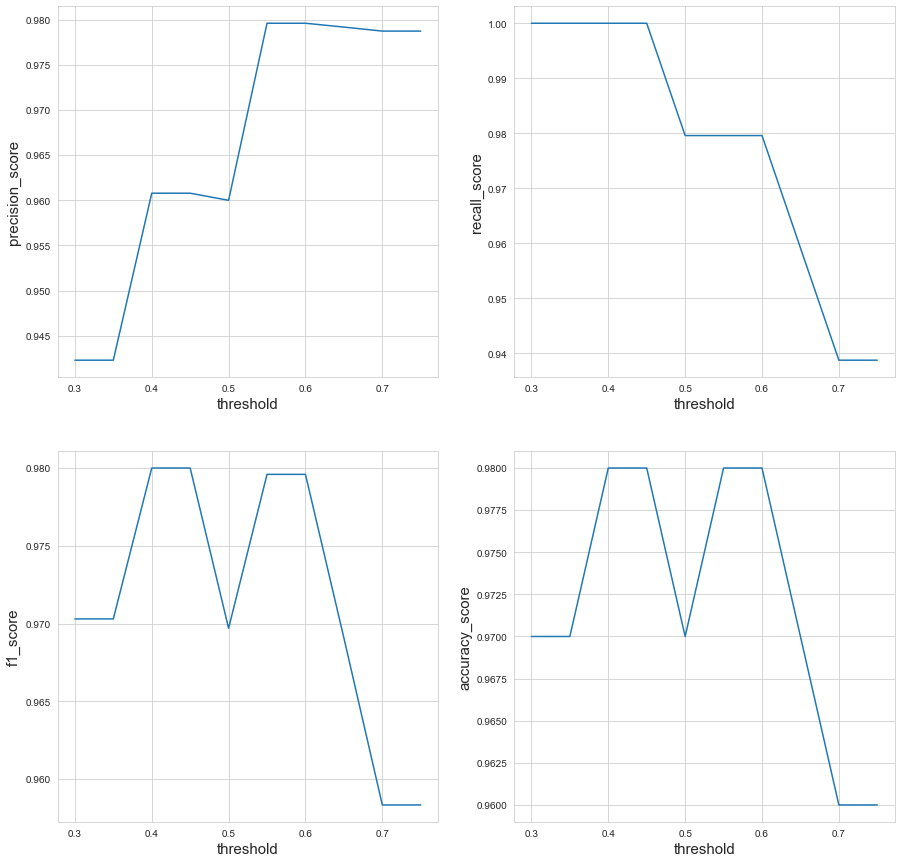

In [43]:
threshold = np.arange(0.3, 0.8, 0.05)

metrics = []
for t in threshold:
    classes = y_pred > t
    metrics.append([precision_score(y, classes),
                    recall_score(y, classes),
                    f1_score(y, classes),
                    accuracy_score(y, classes)])
    
metrics = np.array(metrics)

# построим график для каждого вида метрики
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax = ax.flatten()

labels = ['precision_score', 'recall_score', 'f1_score', 'accuracy_score']
for i in range(4):
    ax[i].plot(threshold, metrics[:, i])
    ax[i].set_xlabel("threshold", fontsize = 15)
    ax[i].set_ylabel(labels[i], fontsize = 15)

На обучающей выборке метрики варьируются не значительно. При этом видно, что с ростом порога precision растет (все меньше ложноположительных ответов), но вот recall падает (все больше ложноотрицательных). **В целом вид графиков сильно варьирует при генерации нового семпла.** 
Окончательный подбор параметра, построение ROC-кривой надо осуществлять на тестовой выборке

#### Задание 3.4. Применение логистической регрессии (5 баллов)

Мы будем использовать данные по свойствам покемонов (https://www.kaggle.com/abcsds/pokemon). В данном задании вам необходимо сначала сделать краткий EDA (Посмотреть на данные и их распределения, а также посмотреть, как различные признаки связаны между собой и с целевой переменной (`Legendary`)).

In [44]:
pokemon = pd.read_csv("Pokemon.csv")
# сразу трансформируем Legendary в численный признак
pokemon['Legendary'] = pokemon['Legendary'].astype(int)
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,0
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,0
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,0
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,0
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,0


In [244]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    int64 
dtypes: int64(10), object(3)
memory usage: 81.4+ KB


Type 2 имеет пропуски почти для половины покемонов. Другие колонки пропусков не имеют

In [245]:
pokemon.describe()

,#,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
count,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000,800.00000
mean,362.813750,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375,0.08125
std,208.343798,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129,0.27339
min,1.000000,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000,0.00000
25%,184.750000,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000,0.00000
50%,364.500000,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000,0.00000
75%,539.250000,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000,0.00000
max,721.000000,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000,1.00000


В целом переменные от Hp до Speed имеют сходные диапазоны, а также средние значения и дисперсии. Переменные Total (, по, видимому сумма всех остальных признаков, это по идее делает ее не особо ценной для модели) и Generation значительно отличаются по диапазонам

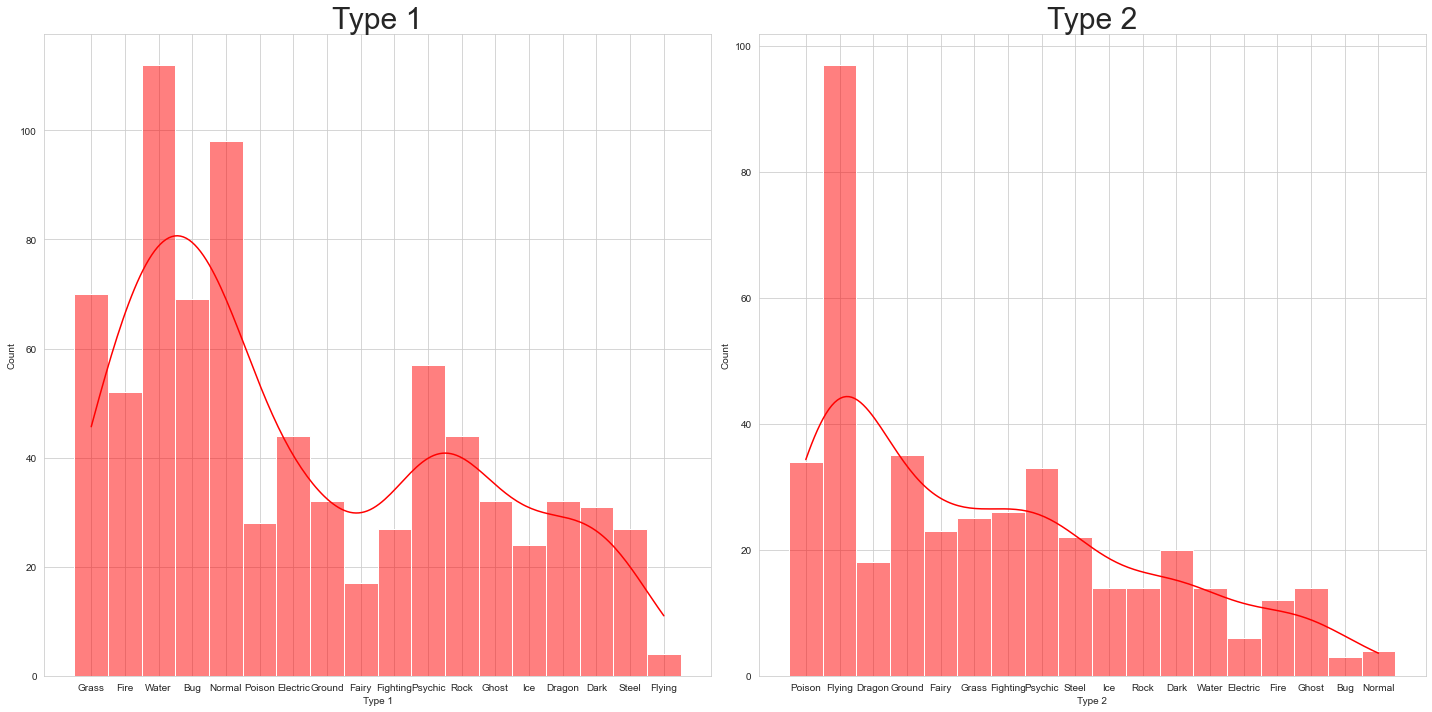

In [267]:
# Распределение переменных Type

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flatten()

features = ['Type 1','Type 2']

for i, f in enumerate(features):
    sns.histplot(pokemon[f], color = 'r', kde=True, ax=axes[i], label=f)
    axes[i].set_title(f, fontsize=30)
    plt.grid()
    plt.tight_layout()

Типов покемонов довольно много, при чем они повторяются между двумя переменными. Видимо потому что некоторые покемоны относятся к двум типам

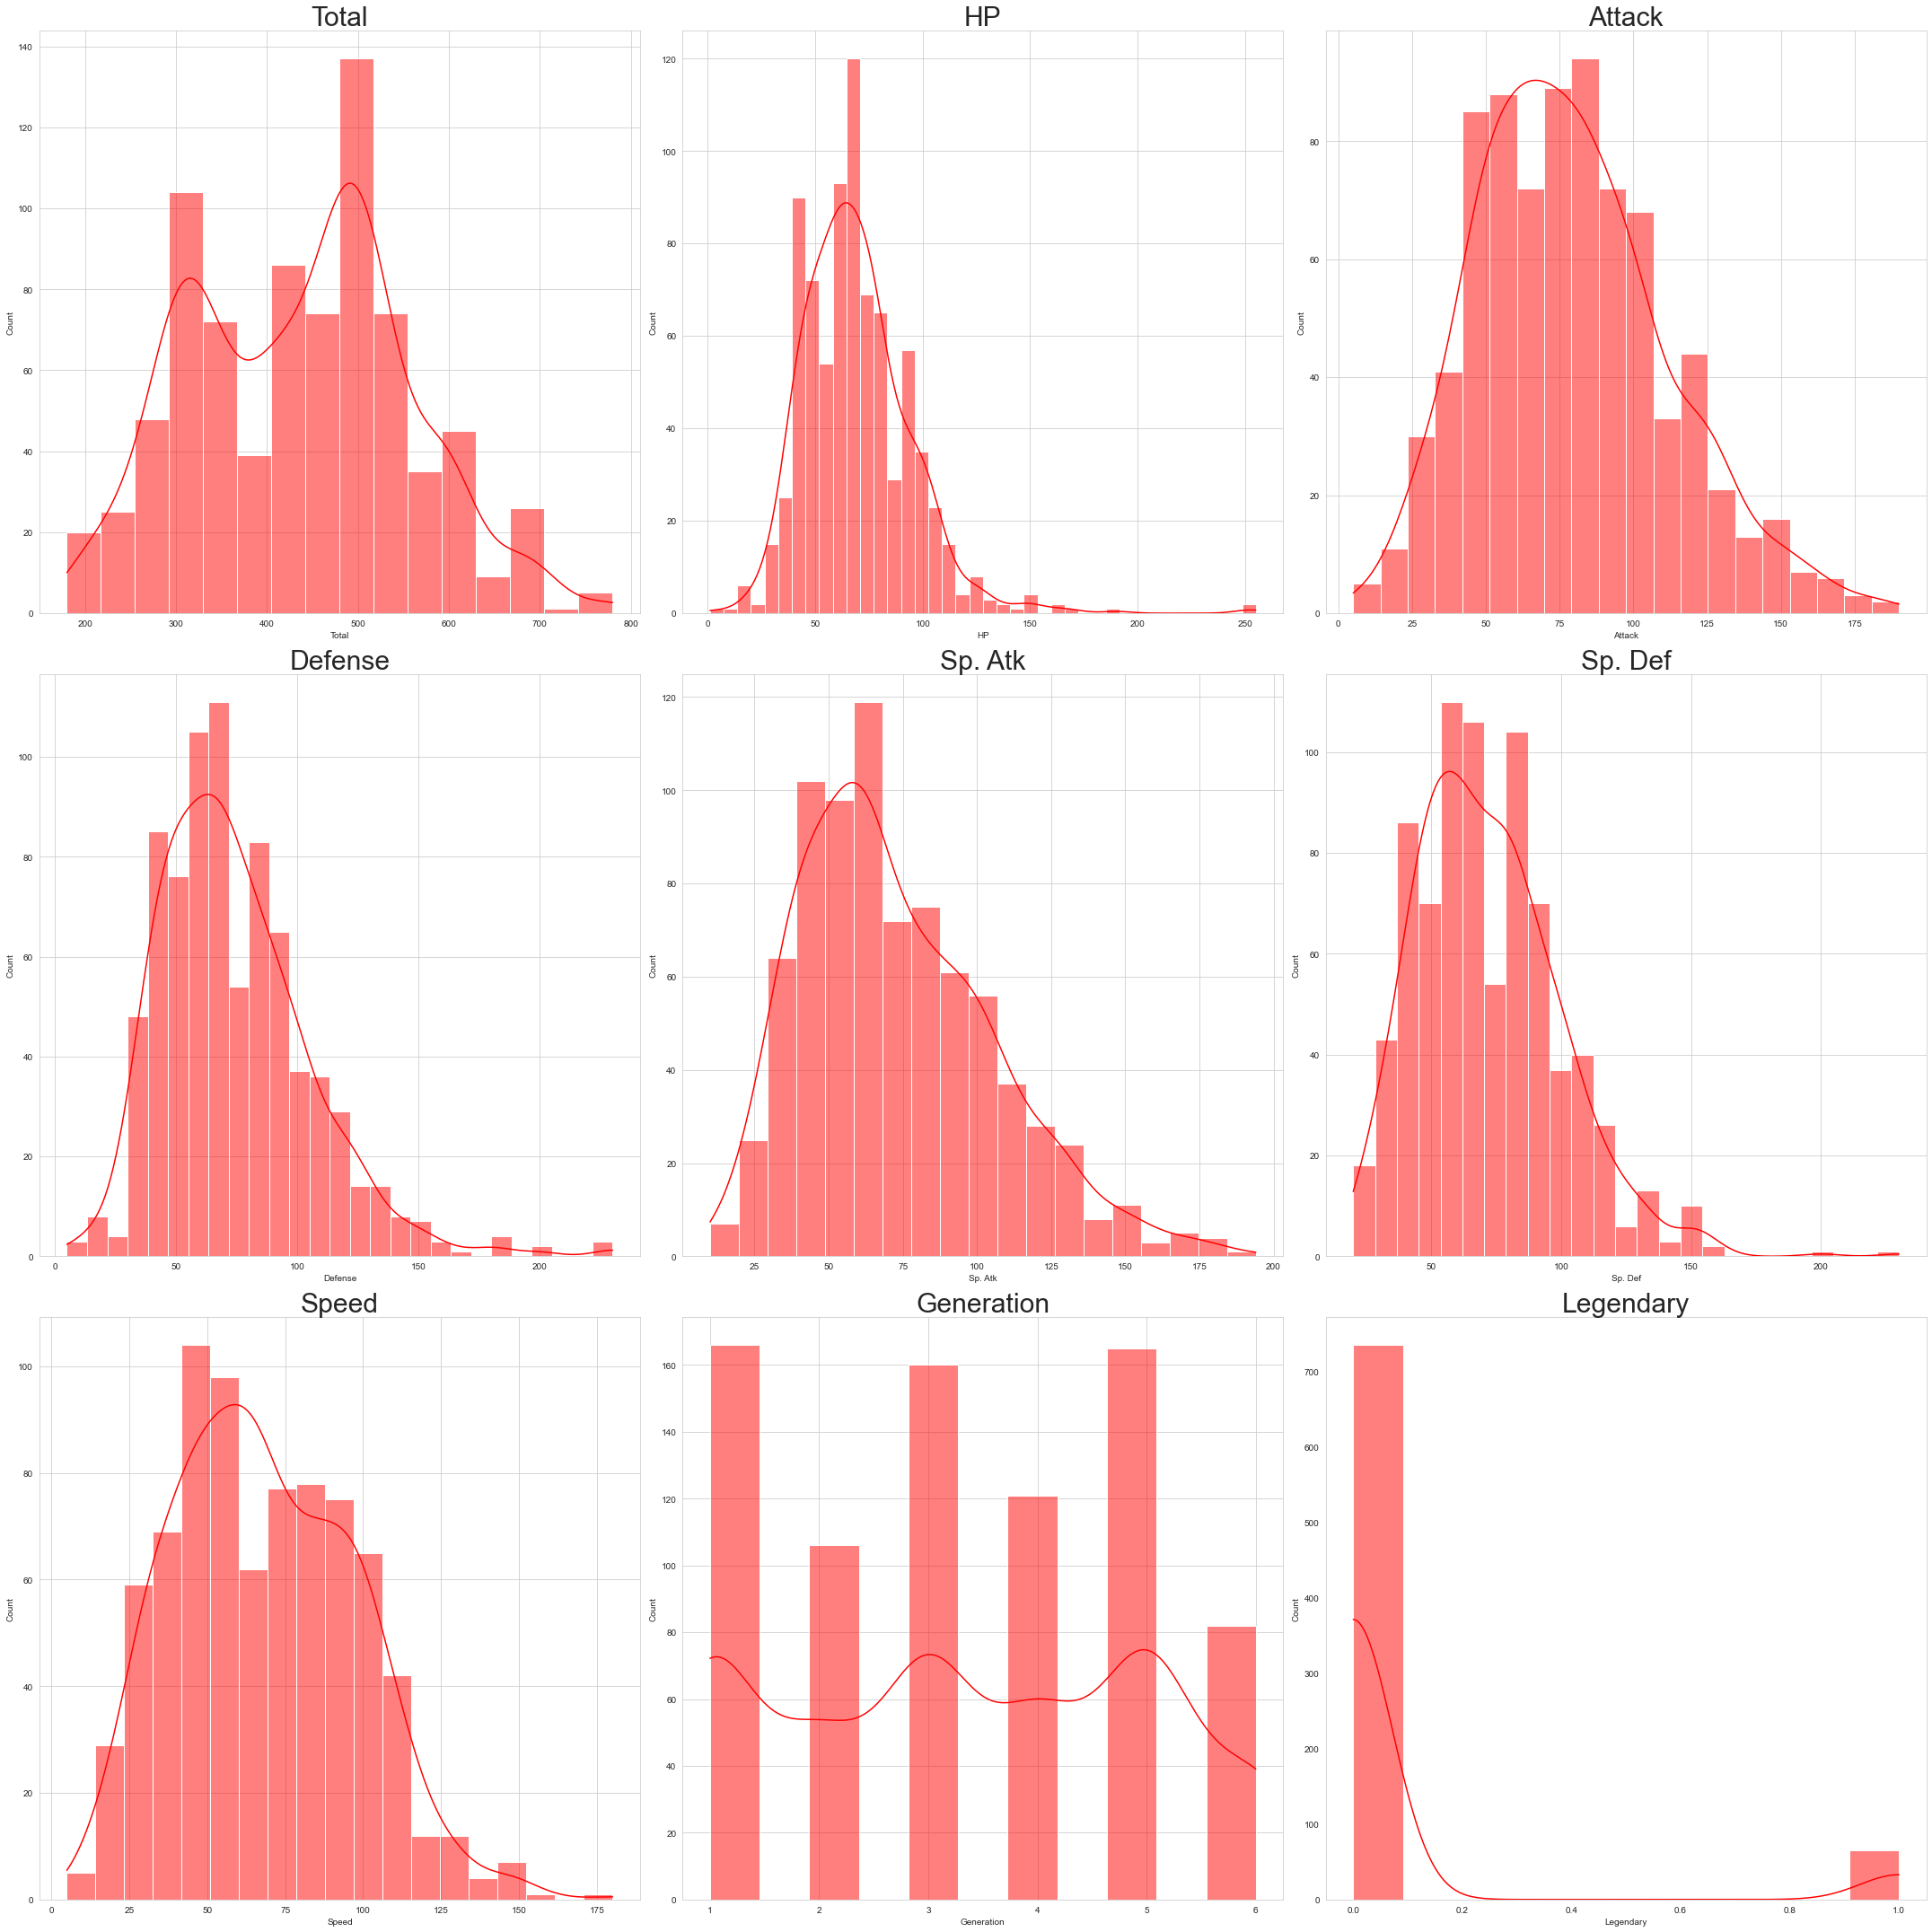

In [45]:
# распределение численных параметров
fig, axes = plt.subplots(3, 3, figsize=(30, 30))
axes = axes.flatten()

features = ['Total','HP','Attack','Defense','Sp. Atk','Sp. Def','Speed','Generation','Legendary']

for i, f in enumerate(features):
    sns.histplot(pokemon[f], color = 'r', kde=True, ax=axes[i], label=f)
    axes[i].set_title(f, fontsize=30)
    plt.grid()
    plt.tight_layout()

Переменные с Total по Speed имеют условно нормальные распределения с хвостами в области больших значений. Generation принимает дискроетные значения от 1 до 6. Для Legendary виден сильный перекос в сторону нелегендарных покемонеов.

<AxesSubplot:>

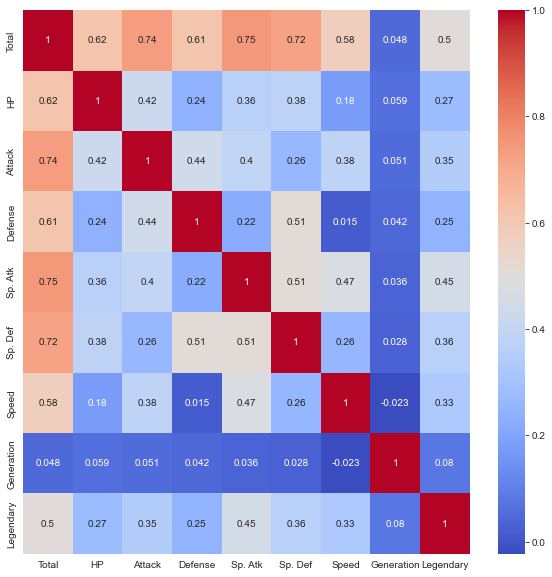

In [46]:
# корреляция между переменными 
plt.figure(figsize=(10,10))
sns.heatmap(pokemon[features].corr(), cmap="coolwarm", annot = True)

- переменная total скоррелирована практически со всеми кроме Generation (к вопросу о том, что это сумма остальных признаков покемонов)
- а Generation в свою очередь не скоррелирован практически ни с чем
- Legendary имеет умеренную корреляцию со всеми переменными кроме Generation
- есть дополнительные корреляции: Defense-Sp.Def, Sp.Atk-Sp.def или Speed

Мы будем предсказывать является ли покемон легендарным или нет. Замените логическое значение колонки на числовое (перекодировав на 0 и 1). Также подумайте, как в этом случае лучше закодировать категориальные признаки (может быть, лучше их просто выбросить?).

- Учитывая, что наши категориальные признаки, 'Type 1' и 'Type 2', не имеют явного порядка (нельзя сравнить grass > fire), то не стоит попросту трансформировать их в численные значения  
- В теории можно было бы трансформировать эти колонки в набор дополнительных фичей, к примеру: фича grass принимает значения 0 или 1 и тд для всех типов. Но учитывая, что типов покемонов довольно много - мы рискуем перегрузить наш датасет. К тмоу же Type 2 содержит значения лишь для половины покемонов
- Можно было бы сконструировать признак 'hаs_two_types', который указывает на количество типов покемона (вдруг покемоны с 2 типами более вероятно оказываются легендарными)
- По крайней мере для начала имеет смысл попробовать обойтись без них, а если модель на основных фичах покажет плохие параметры, то можно попробовать использовать перекодировку Type 1 и 2.

Разделите ваши данные на тестовую и тренировочную выборку.

In [47]:
# получаем необходимые данные
X = pokemon[['Total','HP','Attack','Defense','Sp. Atk','Sp. Def','Speed','Generation']]
y = pokemon['Legendary']

# разбиение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(len(y_train), len(y_test))

560 240


In [48]:
# легендарных покемонов не так много, проверим сколько их вошло в тестовую и обучающую выборки
print(f'{y_train.value_counts()[1]} legendary pokemons in train sample')
print(f'{y_test.value_counts()[1]} legendary pokemons in test sample')

50 legendary pokemons in train sample
15 legendary pokemons in test sample


Пожалуй, довольно оптимальное распределение из возможных
  
Обучите модель `LogisticRegression` из `sklearn`.

In [49]:
pipeline = Pipeline([('scaler', StandardScaler()), ('logistic_regressor', LogisticRegression())])
pipeline.fit(X_train, y_train)
model = pipeline.named_steps['logistic_regressor']

Выведите метрики вашего классификатора:

1. Нарисуйте [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

2. Изобразите ROC кривую и посчитайте площадь под ней.

3. Скажите, какие признаки оказались наиболее важны для модели.

In [50]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

<AxesSubplot:>

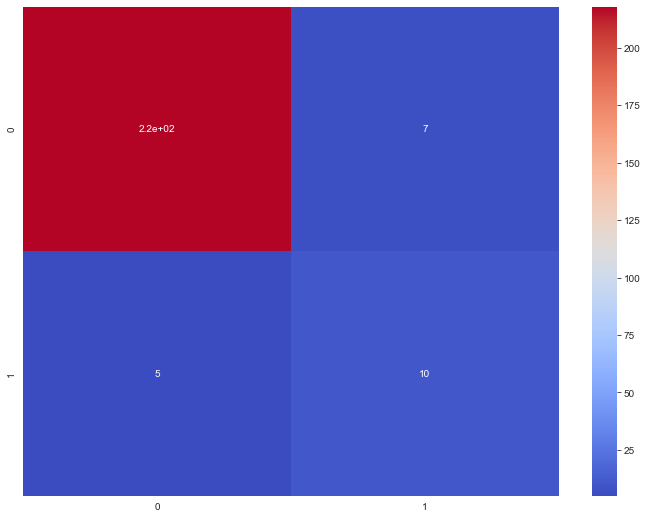

In [51]:
y_pred = pipeline.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, cmap="coolwarm", annot = True)

Видно, что из 15 легендарных покемонов лишь 10 классифицировано верно, а еще 7 ошибочно названы легендларными.

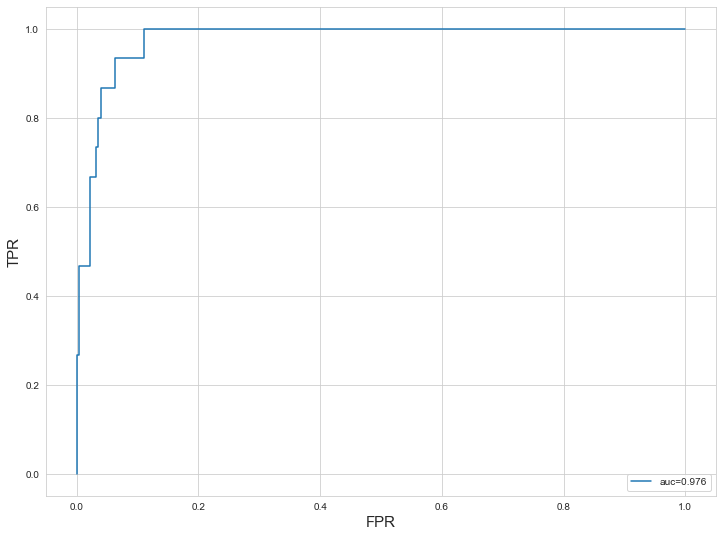

In [52]:
# вероятности отнесения конкретных объектов к 0 или 1 классам
# используем только вероятности для класса 1
y_pred_proba = pipeline.predict_proba(X_test)[::,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label=f"auc={auc}")

plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.legend(loc=4)
plt.show()

ROC-кривая показывает, что на самом деле модель работает хорошо. Дальше вопрос состоит в том, важно ли нам найти всех легендарных покемонов, или минимизировать ложное предсказание.

In [53]:
feature = ['Total','HP','Attack','Defense','Sp. Atk','Sp. Def','Speed','Generation']
coef = model.coef_[0]

for f, c in zip(feature, coef):
    print(f'{f} - {c}')

Total - 1.124419421263885
HP - 0.595323853750362
Attack - 0.27088645530019745
Defense - 0.677672444664641
Sp. Atk - 0.8923569077832126
Sp. Def - 1.0025554041785527
Speed - 1.147313476527064
Generation - 0.7922551571841694


**Не смотря на то, что Generation имеет слабую корреляцию с Legendary, в модели этот параметр имеет заметный весь. К наиюолее важным параметрам относятся: Speed, Sp.def и Total** 
  
**Попробуем проделать то же самое но без переменной Total:**

560 240
50 legendary pokemons in train sample
15 legendary pokemons in test sample


<AxesSubplot:>

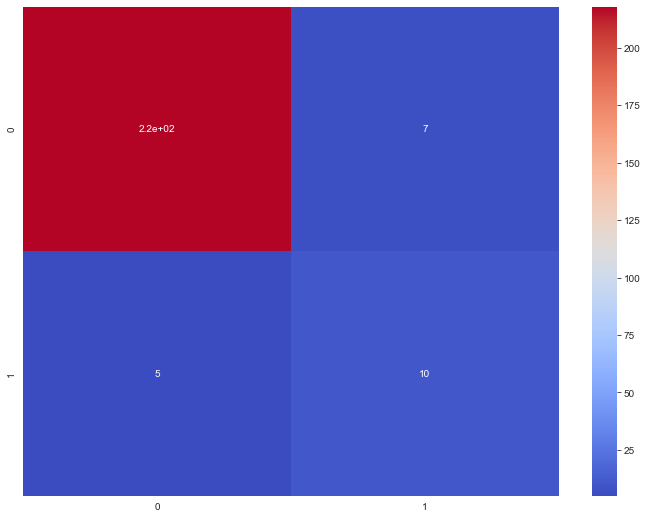

In [54]:
# получаем необходимые данные
X = pokemon[['HP','Attack','Defense','Sp. Atk','Sp. Def','Speed','Generation']]
y = pokemon['Legendary']

# разбиение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(len(y_train), len(y_test))

# легендарных покемонов не так много, проверим сколько их вошло в тестовую и обучающую выборки
print(f'{y_train.value_counts()[1]} legendary pokemons in train sample')
print(f'{y_test.value_counts()[1]} legendary pokemons in test sample')

# обучение модели
pipeline = Pipeline([('scaler', StandardScaler()), ('logistic_regressor', LogisticRegression())])
pipeline.fit(X_train, y_train)
model = pipeline.named_steps['logistic_regressor']

# предсказание и confusion matrix 
y_pred = pipeline.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, cmap="coolwarm", annot = True)

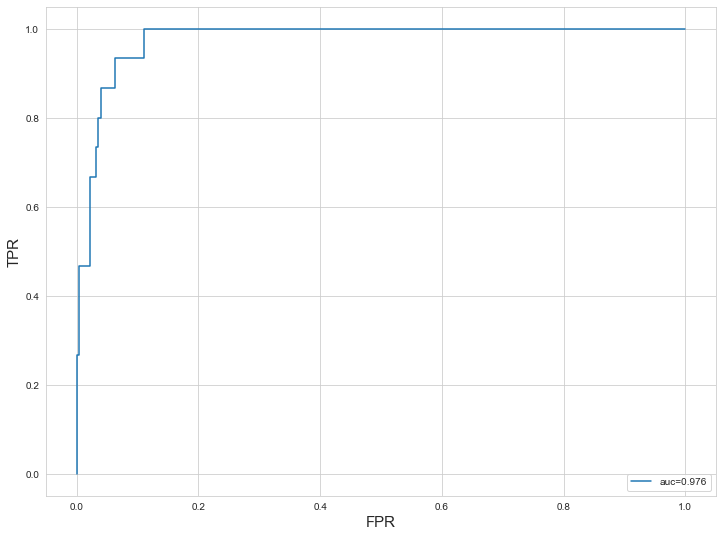

HP - 0.8123286355302773
Attack - 0.556380389722355
Defense - 0.9362156688910317
Sp. Atk - 1.1611976571949763
Sp. Def - 1.2342310005309207
Speed - 1.3763631768797209
Generation - 0.7731461596104892


In [56]:
y_pred_proba = pipeline.predict_proba(X_test)[::,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label=f"auc={auc}")

plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.legend(loc=4)
plt.show()

feature = ['HP','Attack','Defense','Sp. Atk','Sp. Def','Speed','Generation']
coef = model.coef_[0]

for f, c in zip(feature, coef):
    print(f'{f} - {c}')

Тем не менее, видно, что в нашем случае исключение переменной Total не влияет на метрики модели

### Задание 4. Расскажите о вашей любимой музыкальной группе (исполнителе) (0.5 балла)

Расскажите, как вы познакомились с этой группой и скиньте несколько наиболее любимых треков)

Из самого любимого, того к чему я снова и снова возвращаюсь, это **Florence + the Machine**. У Флоренс очень глубокий и эмоциональный голосю Тексты песен мистические, яркие. Клипы наверное на лоюбителя, но в них интересно разбираться, потому что там много символизма, через который Флоренс рассказывает о своей жизни и о своих переживаниях.  
Небольшая подборка любимых треков (со ссылками на спотифай):
- What Kind Of Man (https://open.spotify.com/track/2kP1ujXHn0mNqFbiT3zob8?si=-l4C9MnXTMKJfd3Ox2Z-OQ)
- Delilah (https://open.spotify.com/track/12HB8AmFTovKrFcGG36KbL?si=bVmoucLfTe2So7tPjfgmNA и клип https://www.youtube.com/watch?v=zZr5Tid3Qw4)
- Shake It Out (https://open.spotify.com/track/71iSmEeF0qRVyULABxP75P?si=9lk1VY5ERkyKYR_Rt8DFuA)
- Rabbit Heart (Raise It Up, https://open.spotify.com/track/5jAYbBuwroXXigCj4IGFdA?si=elXe8P9DSHaiEpa8_t1qIg)
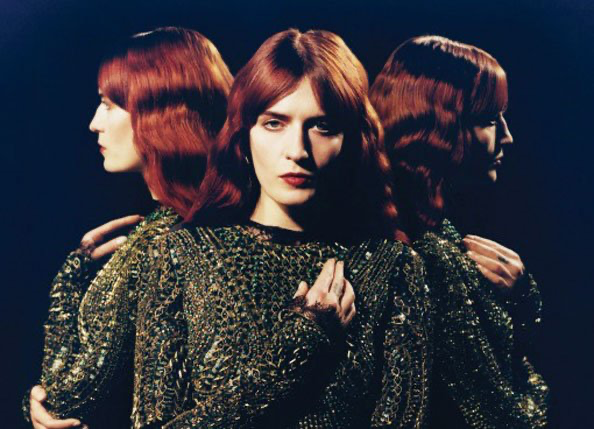

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**

- Интересно и полезно. Учитывая, что мы сейчас проходим классы на питоне - поразбираться с ними тут это полезна комплементарная практика
- Оформлено все супер-красиво и удобно. Спасибо!
- По сложности было все вмеру (не адски сложно, но и не на раз-два). Есть пространство для тиворческого подхода
  
- Очень хотелось бы попробовать какие-нибудь ествественно-научные даптасеты. К примеру предсказание свойств молекул по каким-то дескрипторам. К примеру, вот тут есть датасет из 362 молекул с данными о logBB: https://link.springer.com/article/10.1007/s10822-011-9478-1#article-info (см supplementary table). Не очень удобно, что они в пдф, но если вам покажется это задание интересным, то я заранее могу сделать csv датасет, напихав в него дескрипторов. У меня по работе есть скрипты с rdkit, чтобы это делать